# Footprints: exploratory data analysis cross cell-types

## Setup

In [63]:
import os
import sys
import numpy as np
import anndata as ad
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from upsetplot import from_contents, UpSet

In [8]:
# Ensure cwd is project root and that /code is in path

cwd = os.path.basename(os.getcwd())

if cwd == 'footprintQTL':
    
    PROJECT_DIR = '.'


elif cwd == 'code':
    
    PROJECT_DIR = '..'


elif cwd == 'fichtner':

    PROJECT_DIR = 'projects/footprintQTL'

else:

    PROJECT_DIR = 'manual'


os.chdir(PROJECT_DIR)
sys.path.append(os.getcwd() + '/code')

In [9]:
from helpers.python.utils import list_files_and_links
from helpers.python.anndata_utils import check_anndata

In [10]:
# User variables

min_cells_donor = 200 # Serves as sanity check.
                      # Ideally set to 0 since this filter should be applied during or before footprint computation

from glob_vars import FOOTPRINTS_DIR

## Get data

In [56]:
# Init
peaks_df_entries = [] # Cross-donor stds for all cell types: {'peak': , cell_type': , 'cell_type_ann': , 'mean': , 'std': }
peaks = {} # 'cell_type': [peaks]
hvps = {} # 'cell_type': [hvps]

# Populate
for ct_adata_file in list_files_and_links(FOOTPRINTS_DIR, extension='_processed.h5ad'):

    cell_type = ct_adata_file[11:-15]

    adata = ad.read_h5ad(FOOTPRINTS_DIR + '/' + ct_adata_file)

    check_anndata(adata, min_obs=20, obs_criteria_kwargs=[{'col': 'n_cells', 'func': lambda x: (x > 0).all()}])


    # Stats
    var = adata.var[['mean', 'std', 'highly_variable_std']]

    # Some annotations
    n_donors, n_peaks = adata.shape
    mean_n_cells, mean_n_frags, mean_n_ins = adata.obs[['n_cells', 'n_frags', 'n_insertions']].mean()
    
    for index, row in var.iterrows():
 
        df_entry = {'peak': index,
                    'cell_type': cell_type,
                    'cell_type_ann': cell_type
                                     + f'\nn_peaks={n_peaks}\n'
                                     + f'n_donors={n_donors}\n'
                                     + f'mean_cells={round(mean_n_cells, 1)}\n'
                                     + f'mean_frags={round(mean_n_frags, 1)}\n'
                                     + f'mean_ins={round(mean_n_ins, 1)}',
                    'mean': row['mean'],
                    'std': row['std']}
        
        peaks_df_entries.append(df_entry)


    # Peaks and HVPs
    peaks[cell_type] = adata.var_names

    ct_hvps = var[var['highly_variable_std'] == True].index
    hvps[cell_type] = ct_hvps

    

peaks_df = pd.DataFrame(peaks_df_entries)

## Mean and variance distr. per cell-type

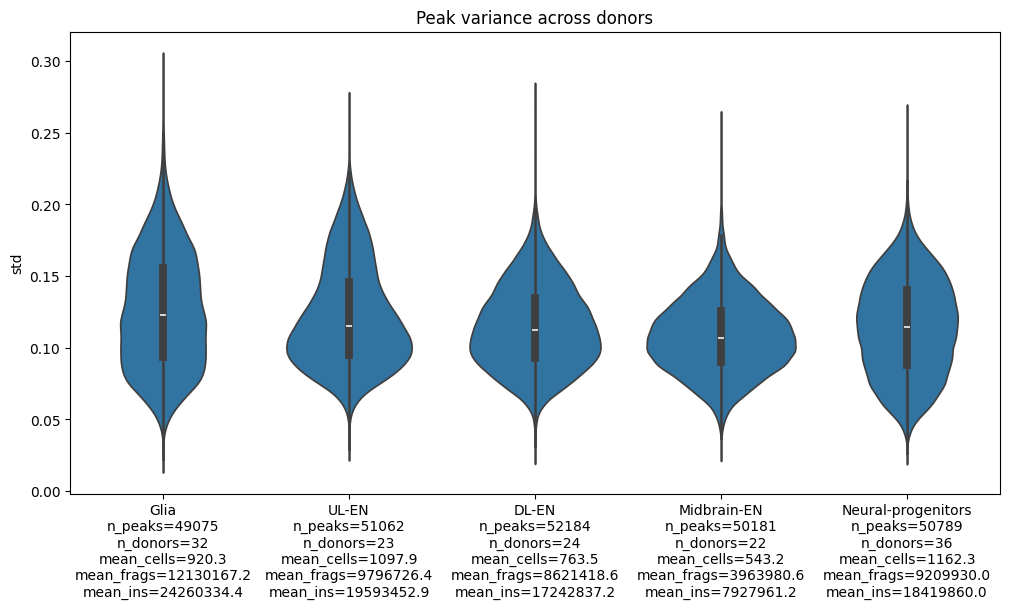

In [57]:
plt.figure(figsize=(12,6))
sns.violinplot(peaks_df, x='cell_type_ann', y='std', inner='box')
plt.title('Peak variance across donors')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('std')
plt.show()

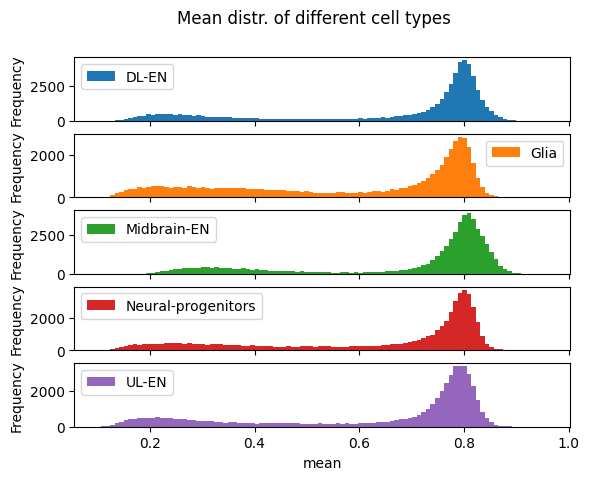

In [58]:
peaks_df_pivot_mean = peaks_df.pivot(columns='cell_type', values='mean')
peaks_df_pivot_mean.plot(kind='hist', bins=100, subplots=True, title='Mean distr. of different cell types', xlabel='mean');

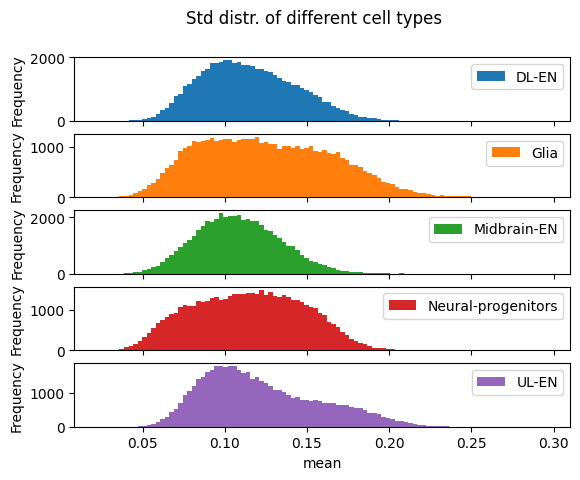

In [59]:
peaks_df_pivot_std = peaks_df.pivot(columns='cell_type', values='std')
peaks_df_pivot_std.plot(kind='hist', bins=100, subplots=True, title='Std distr. of different cell types', xlabel='mean');

## Highly variable peaks

In [60]:
# Create df entries
combs = [[ct1, ct2] for ct1 in hvps.keys() for ct2 in hvps.keys()]

entries = [] # [(ct1, ct2, overlap), ...]

for ct1, ct2 in combs:

    union = set(hvps[ct1]) & set(hvps[ct2])
    entries.append((ct1, ct2, len(union)))

# Make hvp overlap df
overlap_hvps_df = pd.DataFrame(entries, columns=['cell_type_01', 'cell_type_02', 'overlap_count'])
overlap_hvps_df = overlap_hvps_df.pivot(index='cell_type_01', columns='cell_type_02', values='overlap_count')
overlap_hvps_df

cell_type_02,DL-EN,Glia,Midbrain-EN,Neural-progenitors,UL-EN
cell_type_01,,,,,
DL-EN,5218,500,713,1060,1424
Glia,500,4907,399,577,439
Midbrain-EN,713,399,5018,599,729
Neural-progenitors,1060,577,599,5078,1095
UL-EN,1424,439,729,1095,5106


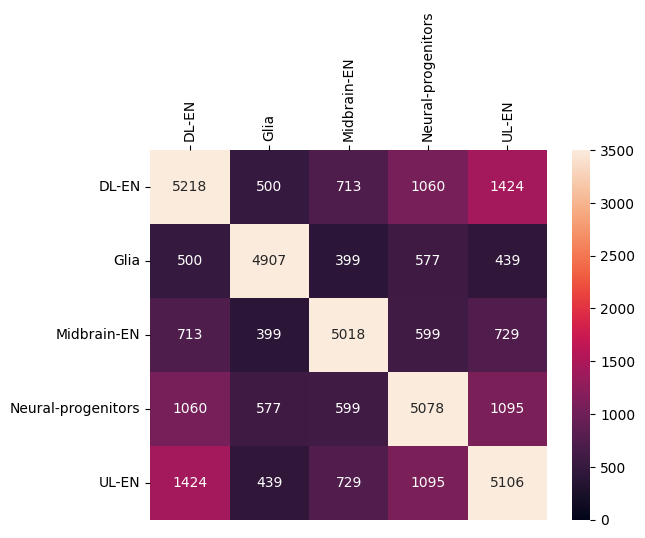

In [61]:
ax = sns.heatmap(overlap_hvps_df, annot=True, fmt='.0f', vmin=0, vmax=3502, cmap='rocket')#, norm=LogNorm(vmin=overlap_df.min().min(), vmax=overlap_df.max().max()))
ax.set(xlabel="", ylabel="")

ax.xaxis.tick_top()
plt.xticks(rotation=90)

plt.show()

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

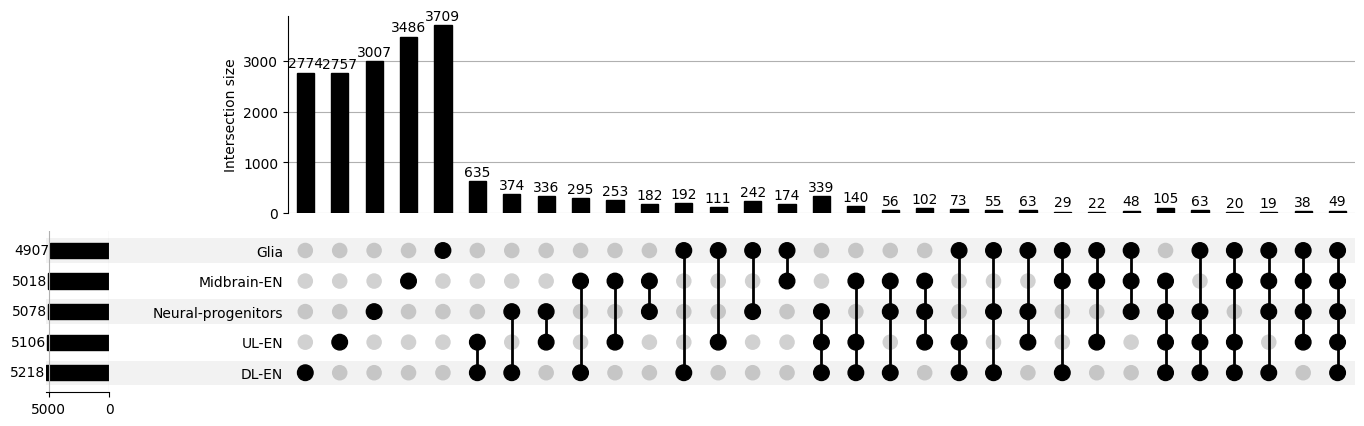

In [64]:
hvps_formatted = from_contents(hvps)
UpSet(hvps_formatted, subset_size='count', show_counts=True).plot()

In [65]:
# What if the original peak sets (non-hvps) already had an overlapping bias?

# Repeat previous plots for original peaks and create an overlap plot with the ration of hvps/peaks

# Create df entries
combs = [[ct1, ct2] for ct1 in peaks.keys() for ct2 in peaks.keys()]

entries = [] # [(ct1, ct2, overlap), ...]

for ct1, ct2 in combs:

    union = set(peaks[ct1]) & set(peaks[ct2])
    entries.append((ct1, ct2, len(union)))

# Make hvp overlap df
overlap_peaks_df = pd.DataFrame(entries, columns=['cell_type_01', 'cell_type_02', 'overlap_count'])
overlap_peaks_df = overlap_peaks_df.pivot(index='cell_type_01', columns='cell_type_02', values='overlap_count')
overlap_peaks_df

cell_type_02,DL-EN,Glia,Midbrain-EN,Neural-progenitors,UL-EN
cell_type_01,,,,,
DL-EN,52184,39980,38833,38896,42170
Glia,39980,49075,36774,36970,39174
Midbrain-EN,38833,36774,50181,37363,38882
Neural-progenitors,38896,36970,37363,50789,38304
UL-EN,42170,39174,38882,38304,51062


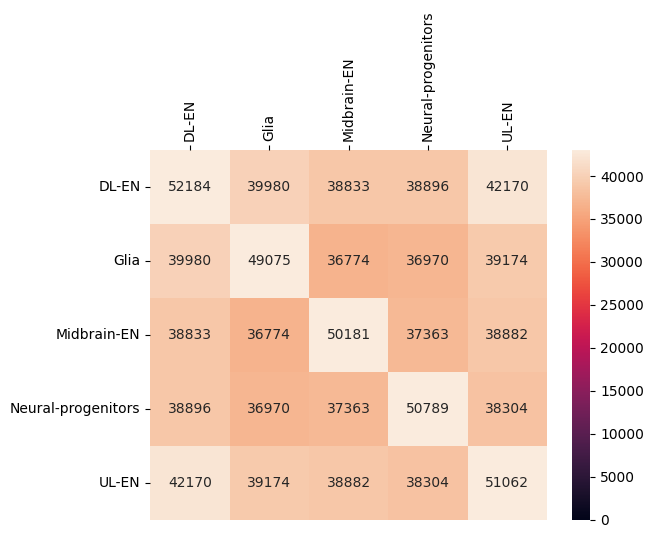

In [66]:
ax = sns.heatmap(overlap_peaks_df, annot=True, fmt='.0f', vmin=0, vmax=43000, cmap='rocket')#, norm=LogNorm(vmin=overlap_df.min().min(), vmax=overlap_df.max().max()))
ax.set(xlabel="", ylabel="")

ax.xaxis.tick_top()
plt.xticks(rotation=90)

plt.show()

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

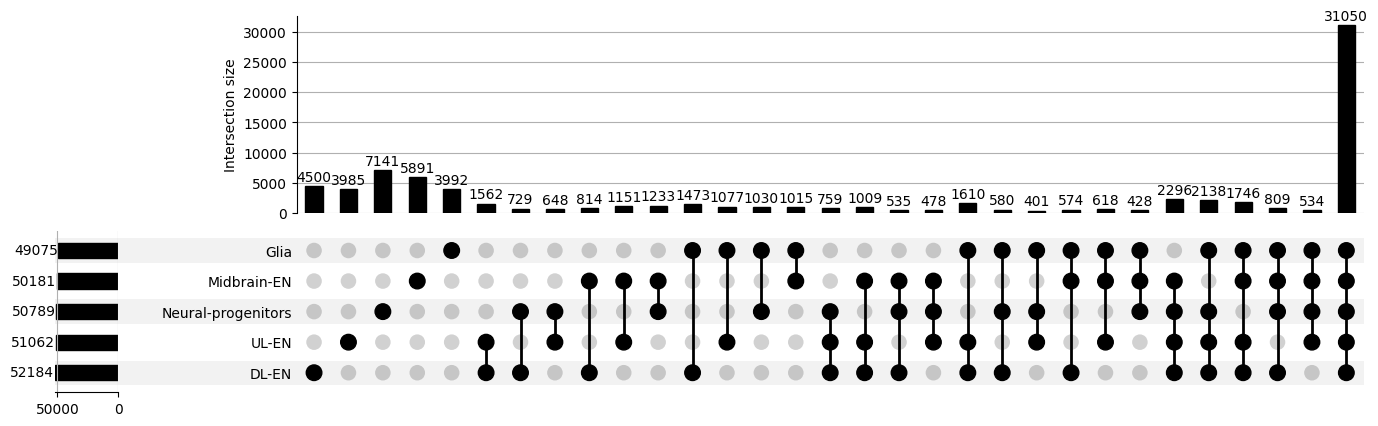

In [67]:
peaks_formatted = from_contents(peaks)
UpSet(peaks_formatted, subset_size='count', show_counts=True).plot()

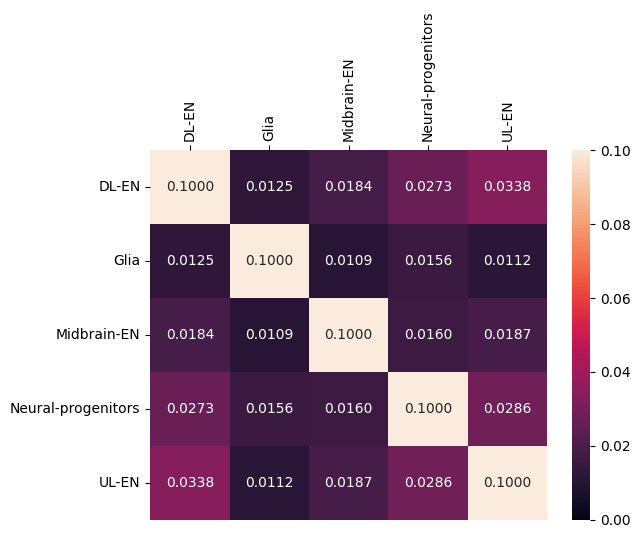

In [68]:
overlap_ratios_df = overlap_hvps_df / overlap_peaks_df

ax = sns.heatmap(overlap_ratios_df, annot=True, fmt='.4f', vmin=0, vmax=0.1,  cmap='rocket')#, norm=LogNorm(vmin=overlap_df.min().min(), vmax=overlap_df.max().max()))
ax.set(xlabel="", ylabel="")

ax.xaxis.tick_top()
plt.xticks(rotation=90)

plt.show()